# **Brain Tumor Detection App**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Imports Libraries and Tools**

In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data
import random
import matplotlib.pyplot as plt


# **Load Datasets**

### **Data Visualization**
This is for the **Training dataset**

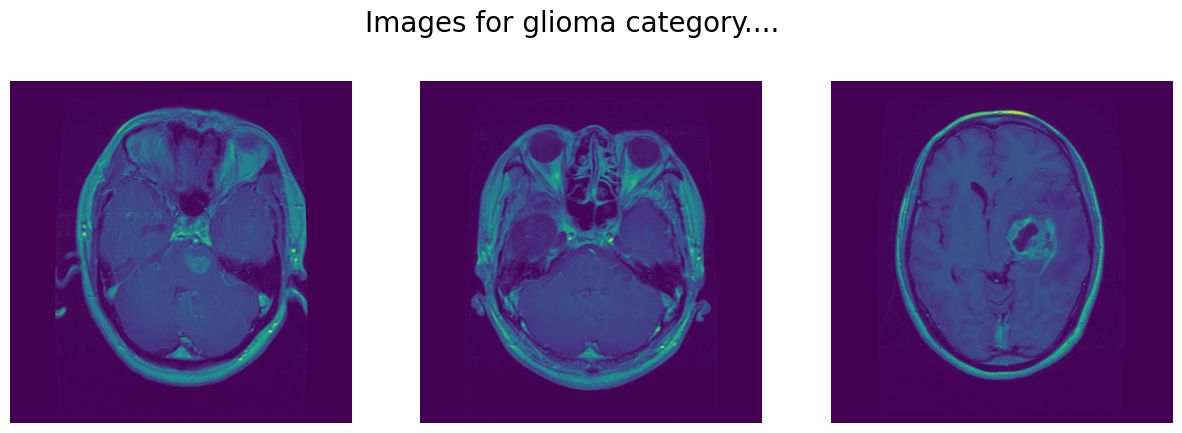

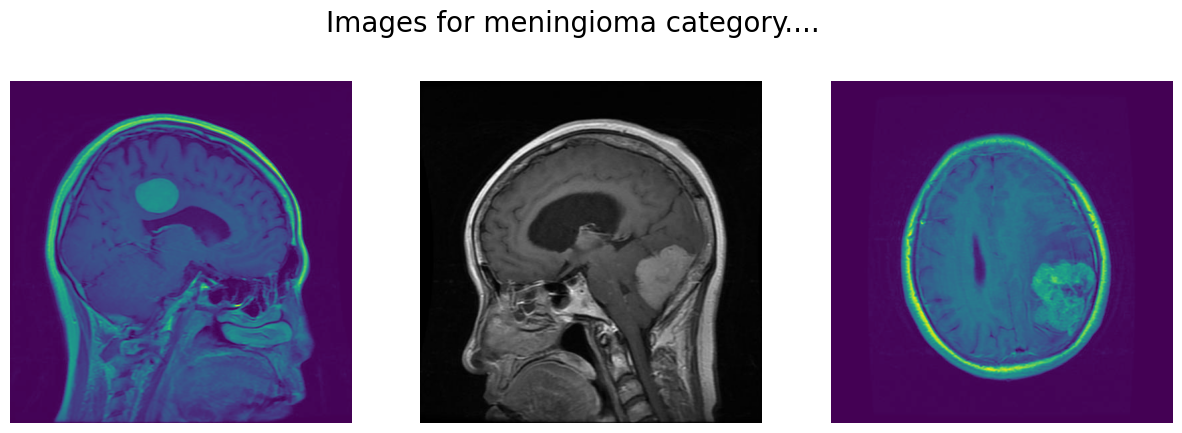

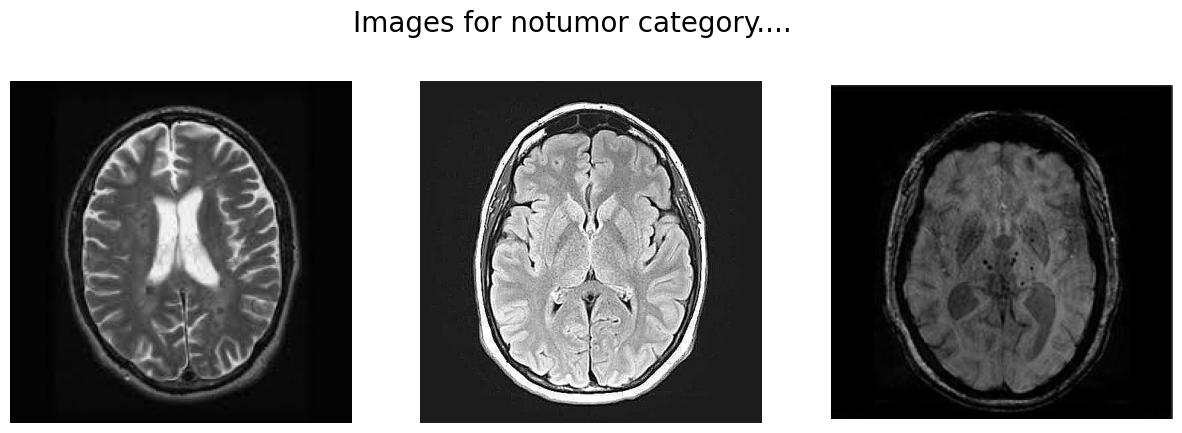

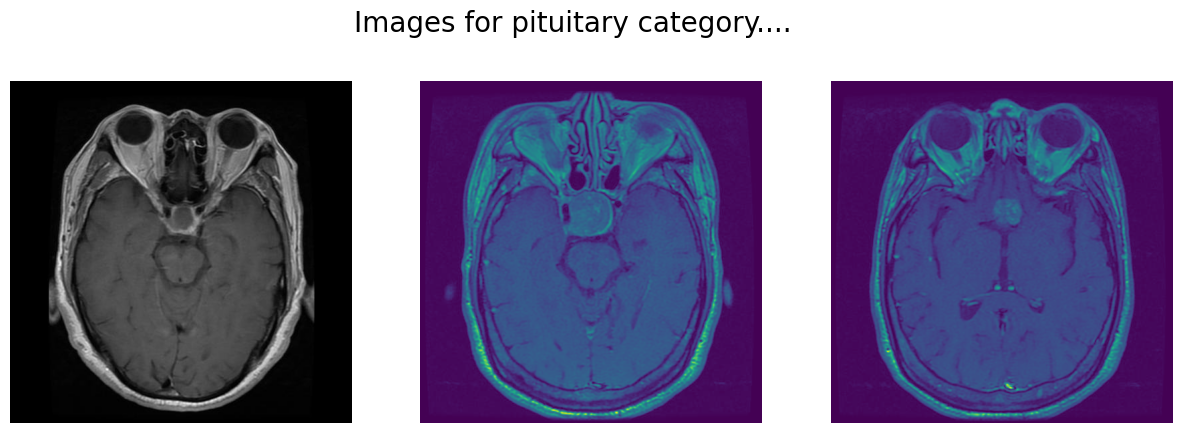

In [4]:
# This is for the Training dataset

train_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Training'

train_paths = []
train_labels = []

classes = sorted(os.listdir(train_dir))

for label in classes:
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

for category in classes:
  image_dir = f'{train_dir}/{category}'
  images = os.listdir(image_dir)

  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(f'Images for {category} category....', fontsize=20)

  for i in range(3):
    k = np.random.randint(0, len(images))
    img = np.array(Image.open(f'{train_dir}/{category}/{images[k]}'))
    ax[i].imshow(img)
    ax[i].axis('off')
  plt.show()

### **Data Visualization**
This is for the **Testing dataset**

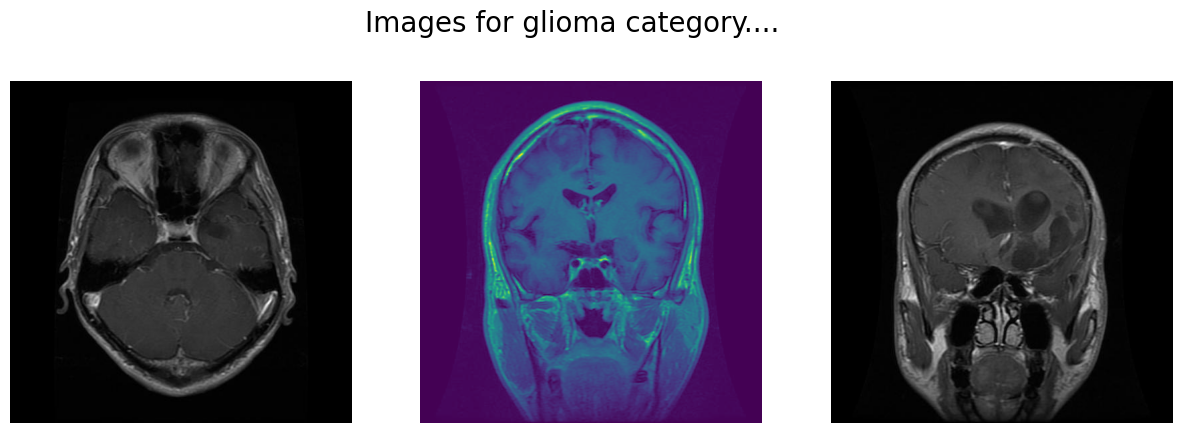

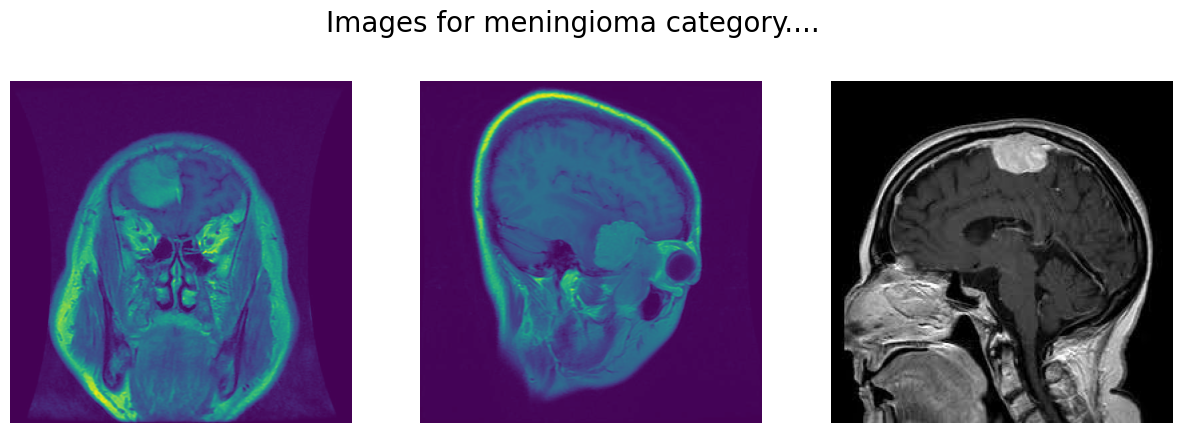

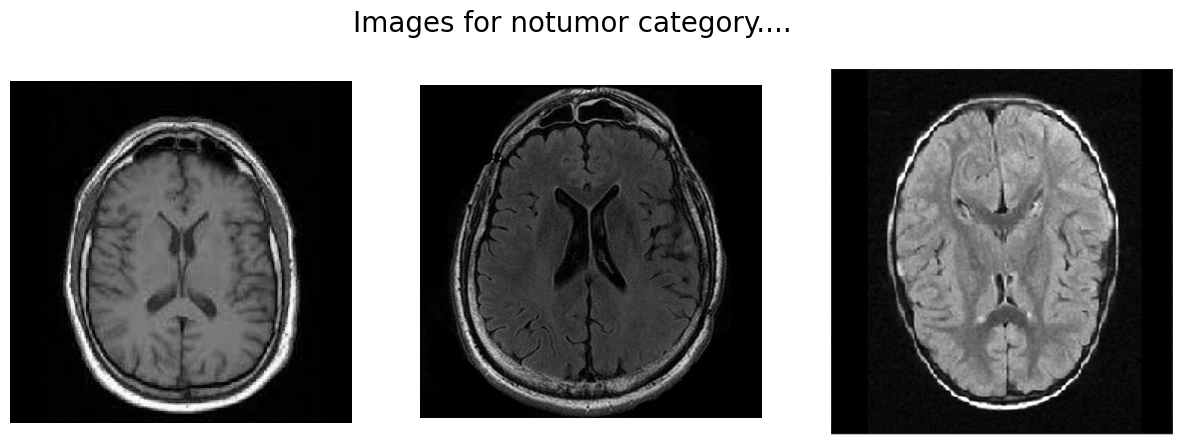

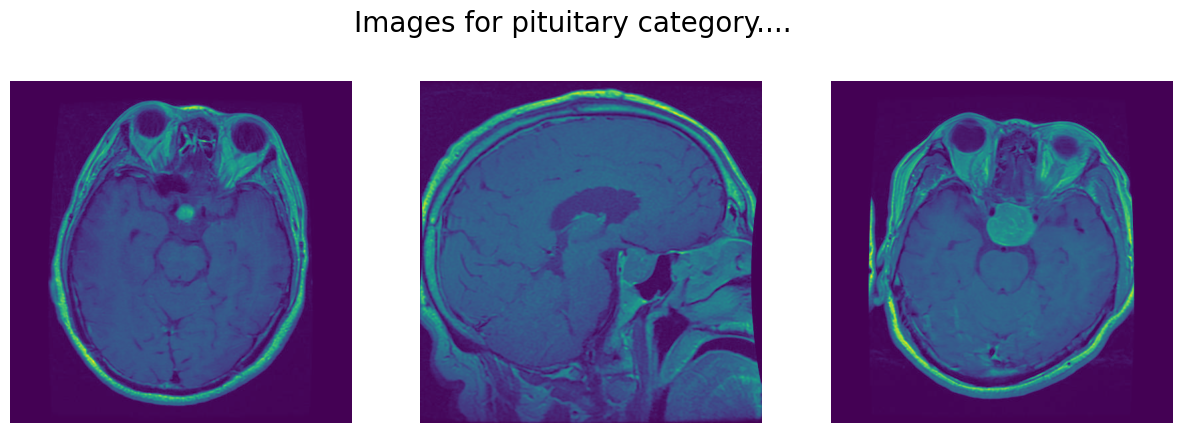

['/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-glTr_0003.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-glTr_0002.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-glTr_0000.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-glTr_0001.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-glTr_0006.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-glTr_0005.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-glTr_0004.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-gl_0017.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-gl_0094.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-gl_0218.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-gl_0268.jpg', '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-gl_0165.jpg', '/content/drive/MyDrive/C

In [5]:
# This is for the testing dataset

test_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing'

test_paths = []
test_labels = []

classes = sorted(os.listdir(test_dir))

for label in classes:
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

for category in classes:
  image_dir = f'{test_dir}/{category}'
  images = os.listdir(image_dir)

  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(f'Images for {category} category....', fontsize=20)

  for i in range(3):
    k = np.random.randint(0, len(images))
    img = np.array(Image.open(f'{test_dir}/{category}/{images[k]}'))
    ax[i].imshow(img)
    ax[i].axis('off')
  plt.show()

print(test_paths)
print(test_labels)

# **Image Preprocessing (Helper Functions)**

In [6]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image, dtype=np.float32) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))  # Ensure order is always the same
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    encoded = [label_map[label] for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch


# **MODEL:**
## **WE ARE USING VGG16 FOR TRANSFER LEARNING.**
The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 128
batch_size = 20
epochs = 10  # Increased epochs

# Ensure consistent label encoding
unique_labels = sorted(os.listdir(train_dir))
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse'
)

# Load pre-trained VGG16 model
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze most layers, but fine-tune last 6
for layer in base_model.layers[:-6]:
    layer.trainable = False
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Build final model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(unique_labels), activation='softmax')
])

# Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Train model
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

Found 5715 images belonging to 4 classes.
Found 5715 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2971s 10s/step - loss: 0.8239 - sparse_categorical_accuracy: 0.6526 - val_loss: 0.4343 - val_sparse_categorical_accuracy: 0.8394
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2966s 10s/step - loss: 0.3448 - sparse_categorical_accuracy: 0.8669 - val_loss: 0.2552 - val_sparse_categorical_accuracy: 0.9038
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2882s 10s/step - loss: 0.2700 - sparse_categorical_accuracy: 0.9043 - val_loss: 0.1818 - val_sparse_categorical_accuracy: 0.9351
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2890s 10s/step - loss: 0.2224 - sparse_categorical_accuracy: 0.9139 - val_loss: 0.1437 - val_sparse_categorical_accuracy: 0.9430
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2889s 10s/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9352 - val_loss: 0.1495 - val_sparse_categorical_accuracy: 0.9442
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2924s 10s/step - loss: 0.1616 - sparse_categorical_accuracy: 0.9441 - val_loss: 0.1570 - val_sparse_categorical_acc

# **Train and Val Plots**

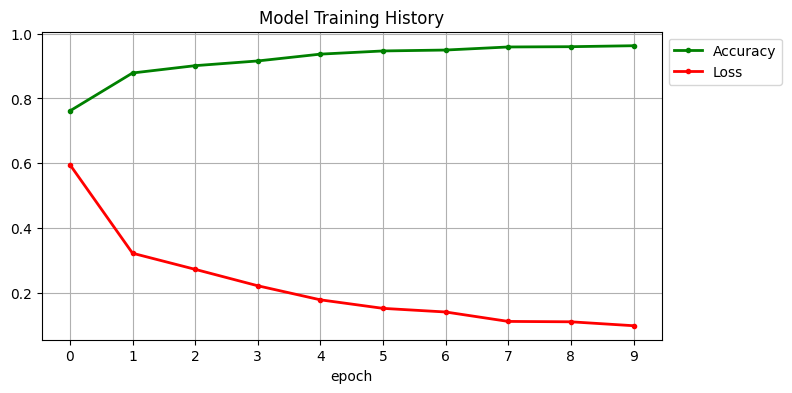

In [8]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# **Model Classification Report**

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np
import collections

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# Count predicted labels
predicted_classes = np.argmax(test_predictions, axis=1)
predicted_counts = collections.Counter(predicted_classes)

print("Predicted Class Distribution:", predicted_counts)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 273s 7s/step
Predicted Class Distribution: Counter({np.int64(2): 410, np.int64(1): 310, np.int64(3): 309, np.int64(0): 282})
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       300
           1       0.92      0.93      0.93       306
           2       0.99      1.00      0.99       405
           3       0.95      0.98      0.96       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# **Model Confusion Plot**

Confusion Matrix:
[[274  21   2   3]
 [  4 286   4  12]
 [  0   0 404   1]
 [  4   3   0 293]]


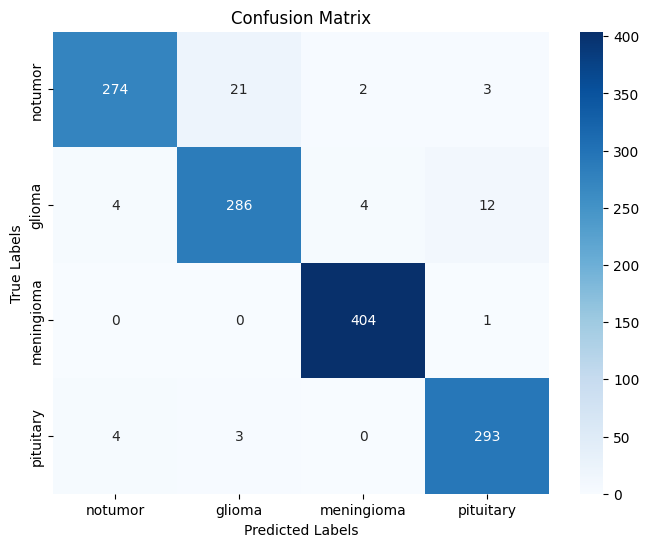

In [10]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# **Roc Curve Plot**

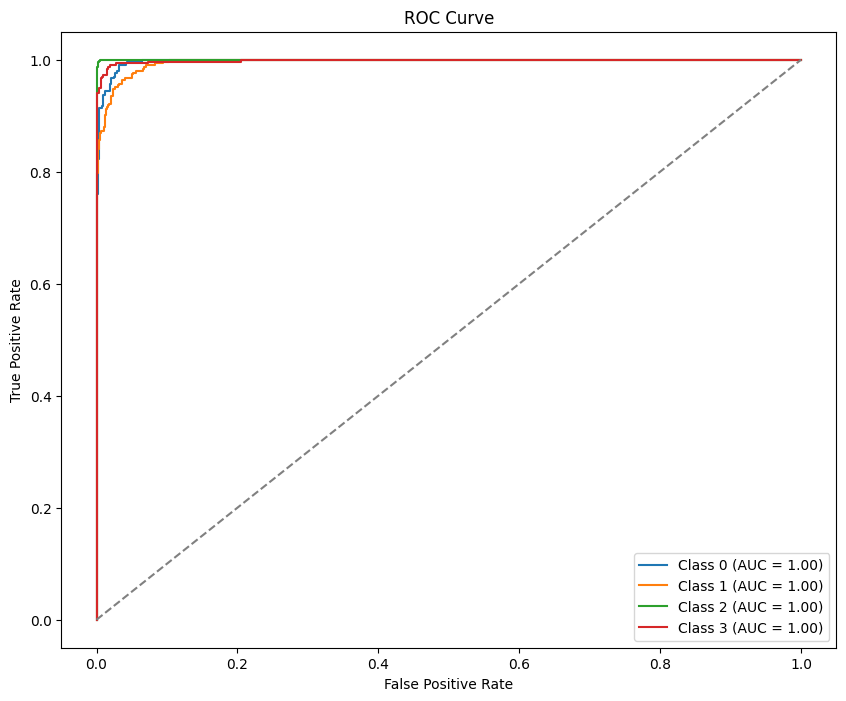

In [11]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# **Save & Load Model**

In [12]:
# Save the entire model
model.save('model.h5')

In [20]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# **MRI Tumor Detection System**

In [21]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


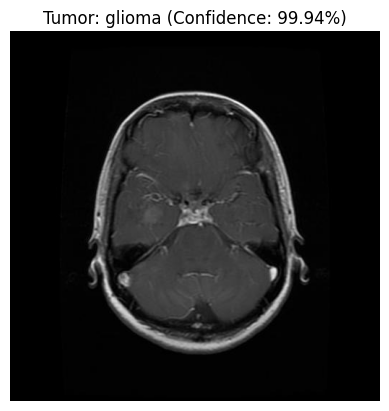

In [22]:
# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/glioma/Te-gl_0013.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


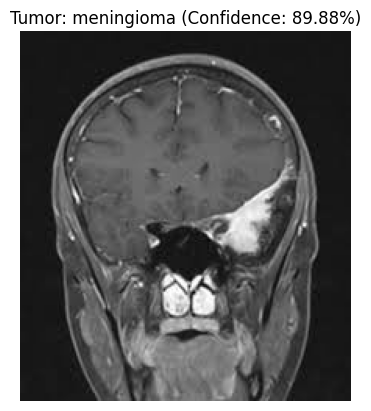

In [23]:
# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/meningioma/Te-meTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


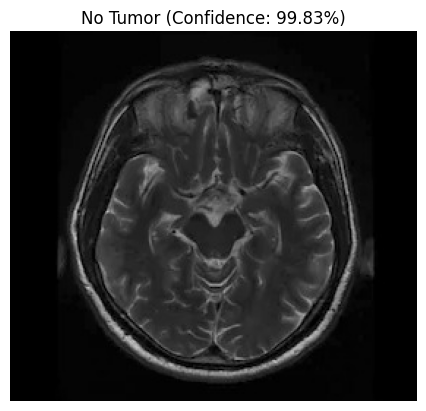

In [24]:
# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/notumor/Te-noTr_0006.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


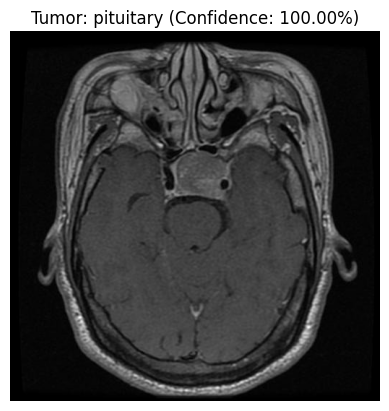

In [25]:
# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing/pituitary/Te-pi_0026.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)